**Goals**

To build an object detection model that adapts to a new domain by leveraging labeled data from a source domain and unlabeled data from a target domain. This can improve the model's performance when the target domain has a different distribution of images compared to the source domain.

**Source Datasets** - The Pascal VOC 2012 dataset is a widely used benchmark in computer vision tasks like object detection, semantic segmentation, and classification. It contains 20 object categories, including animals (e.g., cat, dog, bird), vehicles (e.g., car, bicycle, train), and household items (e.g., chair, sofa, TV)

**Target dataset** - For the target dataset, we will continue to use the Pascal VOC 2012 dataset. However, we will shift its distribution by altering the color, contrast, brightness, or by adding noise.

**Imports**

In [1]:
import os

import numpy as np

import random
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import tqdm
import time

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.datasets import VOCDetection
from torchvision.transforms import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from torch.amp import GradScaler, autocast

from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
source_paths_annotations = os.path.join(path, "VOC2012_train_val/VOC2012_train_val")
# walk_through_dir(train_paths)

target_paths = os.path.join(path, "VOC2012_test/VOC2012_test")
# walk_through_dir(target_paths)

In [6]:
source_paths_images = os.path.join(source_paths_annotations, "JPEGImages")
source_paths_annotations = os.path.join(source_paths_annotations, "Annotations")

target_paths = os.path.join(target_paths, "JPEGImages")

# target_paths_annotations = os.path.join(target_paths, "Annotations")

In [7]:
# Path to the Annotations folder
annotations_dir = '/root/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations'

# Get a random annotation file
annotation_files = os.listdir(source_paths_annotations)
random_annotation = random.choice(annotation_files)

# Parse the XML file
annotation_path = os.path.join(source_paths_annotations, random_annotation)
tree = ET.parse(annotation_path)
root = tree.getroot()

# Display the details
print(f"Annotation File: {random_annotation}")
for obj in root.findall('object'):
    name = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = bndbox.find('xmin').text
    ymin = bndbox.find('ymin').text
    xmax = bndbox.find('xmax').text
    ymax = bndbox.find('ymax').text
    print(f"Object: {name}, Bounding Box: ({xmin}, {ymin}, {xmax}, {ymax})")


Annotation File: 2007_005951.xml
Object: motorbike, Bounding Box: (185, 62, 498, 301)
Object: person, Bounding Box: (329, 36, 468, 272)


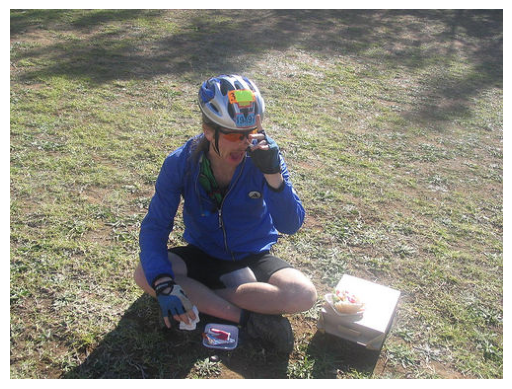

Displayed: 2008_003933.jpg


In [8]:


# Path to the folder containing actual images
image_dir = '/root/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages'

# Get a random image filename
image_files = os.listdir(image_dir)
random_image = random.choice(image_files)

# Load and display the image
image_path = os.path.join(image_dir, random_image)
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')  # Turn off axis for better display
plt.show()

print(f"Displayed: {random_image}")


**Data Processing**

In [9]:
def shift_distribution(image, shift_type="color", intensity=1):
    """
    Applies a domain shift to the input image to simulate a target domain distribution.

    Parameters:
        image (PIL.Image or torch.Tensor): The input image.
        shift_type (str): The type of shift to apply. Options are "color", "brightness", "contrast", "noise", or "blur".
        intensity (float): Intensity of the transformation. Ranges from 0 (no change) to 1 (maximum effect).

    Returns:
        PIL.Image: The shifted image.
    """
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)

    if shift_type == "color":
        # Adjust the color balance
        transform = transforms.ColorJitter(saturation=intensity, hue=0.5)
    elif shift_type == "brightness":
        # Modify brightness
        transform = transforms.ColorJitter(brightness=intensity)
    elif shift_type == "contrast":
        # Modify contrast
        transform = transforms.ColorJitter(contrast=intensity)
    elif shift_type == "noise":
        # Add random Gaussian noise
        def add_noise(img):
            array = transforms.ToTensor()(img).numpy()
            noise = intensity * random.randn(*array.shape)  # Additive Gaussian noise
            array = array + noise
            array = array.clip(0, 1)  # Ensure values are within valid range
            return transforms.ToPILImage()(torch.tensor(array))
        transform = add_noise
    elif shift_type == "blur":
        # Apply a Gaussian blur
        transform = transforms.GaussianBlur(kernel_size=5, sigma=intensity)
    else:
        raise ValueError("Invalid shift_type. Choose from 'color', 'brightness', 'contrast', 'noise', or 'blur'.")

    return transform(image)


In [10]:
class CustomVacDataset(Dataset):
  def __init__(self, image_root, annotated_root=None , shift_type='blur', intensity=0.5,  transforms=None):
    self.image_root = image_root
    self.annotated_root = annotated_root
    self.transforms = transforms
    self.img_ids = [os.path.splitext(file)[0] for file in os.listdir(image_root)]
    self.shift_type = shift_type
    self.intensity = intensity

  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, index):
    # Get image ID
    image_id = self.img_ids[index]

    # Load image
    img_path = os.path.join(self.image_root, f'{image_id}.jpg')
    image = Image.open(img_path).convert('RGB')

    target = {"boxes": torch.tensor([]), "labels": torch.tensor([]), "image_id": torch.tensor([index])}
    # Load annotation
    if self.annotated_root:
      annot_path = os.path.join(self.annotated_root, f'{image_id}.xml')
      boxes, labels = self.parse_annoted(annot_path)
      target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
      target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

    if self.shift_type:
      image = shift_distribution(image, self.shift_type, self.intensity)

    # Apply transformations (if any)
    if self.transforms:
        image = self.transforms(image)

    return image, target


  def parse_annoted(self, annotated_root):
    tree = ET.parse(annotated_root)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
      # get label class name
      label = obj.find('name').text
      labels.append(self.class_to_label(label))

      # get bounding boxes
      bbox = obj.find('bndbox')
      xmin = float(bbox.find('xmin').text)
      ymin = float(bbox.find('ymin').text)
      xmax = float(bbox.find('xmax').text)
      ymax = float(bbox.find('ymax').text)
      boxes.append([xmin, ymin, xmax, ymax])

    return boxes, labels

  def class_to_label(self, class_name):
      # Pascal VOC class labels (map class name to integer)
      voc_classes = [
          "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable",
          "dog", "horse", "motorbike", "person", "pottedplant",
          "sheep", "sofa", "train", "tvmonitor"
      ]
      return voc_classes.index(class_name) + 1  # Classes are 1-indexed in Pascal VOC

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
# simple transformers
simple_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Simple transforms with augmentation
augmented_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
])

In [13]:
# Create dataset object
source_train_dataset = CustomVacDataset(image_dir, annotations_dir, transforms=augmented_transforms)

target_dataset = CustomVacDataset(target_paths, annotated_root=None, shift_type='color', intensity=1, transforms=simple_transforms)

In [14]:
# Example: Access a sample
# image, target = source_train_dataset[0]
# print("Image shape:", image.shape)
# print("Target:", target)

In [15]:
# Assume `full_dataset` is your Dataset object
dataset_size = len(source_train_dataset)
target_dataset_size = len(target_dataset)
# print(f"Source Dataset Size: {dataset_size}, Target Dataset Size: {target_dataset_size}")

# Create a list of random indices for 10% of the dataset
source_subset_indices = np.random.choice(range(dataset_size), size=int(dataset_size * 0.2), replace=False)
target_subset_indices = np.random.choice(range(target_dataset_size), size=int(target_dataset_size * 0.2), replace=False)
# Create a Subset object
source_subset = Subset(source_train_dataset, source_subset_indices)
target_subset = Subset(target_dataset, target_subset_indices)
# Create a DataLoader for the subset
ten_percent_source_subset_loader = DataLoader(source_subset, batch_size=16, shuffle=True, collate_fn=collate_fn,  num_workers=4)
ten_percent_target_subset_loader = DataLoader(target_subset, batch_size=16, shuffle=True, collate_fn=collate_fn,  num_workers=4)

In [16]:
source_len = len(ten_percent_source_subset_loader)
target_len = len(ten_percent_target_subset_loader)
print(f"Source Loader Length: {source_len}, Target Loader Length: {target_len}")



Source Loader Length: 215, Target Loader Length: 202


In [17]:
# Create DataLoader
source_train_dataloader = DataLoader(source_train_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn)

target_dataloader = DataLoader(target_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn)

**Models**

Faster R-CNN Model

In [18]:
# Model
faster_rcnn = fasterrcnn_resnet50_fpn(weights='DEFAULT')


num_classes = 21


for name, param in faster_rcnn.backbone.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
faster_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


**GradientReversalLayer**

During backpropagation, the GRL multiplies the gradient by a negative scalar. This effectively reverses the gradient's direction, encouraging the model to learn features that are less sensitive to domain-specific variations.

In [19]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha=1):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReverseLayer(nn.Module):
    def __init__(self, alpha=1):
        super(GradientReverseLayer, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)


Domain Discriminator

In [20]:
class DomainDiscriminator(nn.Module):
    def __init__(self, in_features=12544, hidden_size=256):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size),  # Add BatchNorm after the first Linear layer
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),  # Add BatchNorm after the second Linear layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),  # Add BatchNorm after the third Linear layer
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()  # Output binary domain classification probability
        )

    def forward(self, x):
        return self.discriminator(x)


In [21]:
def extract_features(model, images):
    """
    Extract features from the backbone of Faster R-CNN.
    Args:
    - model: Faster R-CNN model
    - images: Batched images as a single tensor
    Returns:
    - Pooled features (flattened)
    """
    # Convert list of images to a batched tensor
    batched_images = torch.stack(images)

    # Pass batched images through the backbone
    backbone_output = model.backbone(batched_images)

    # Extract features from one specific feature map (e.g., the first level)
    features = backbone_output["0"]  # Select appropriate feature map key ("0" for ResNet50)
    pooled_features = nn.AdaptiveAvgPool2d((7, 7 ))(features)
    pooled_features = torch.flatten(pooled_features, start_dim=1)  # Flatten feature maps
    return pooled_features


Training Loops

In [22]:
domain_discriminator = DomainDiscriminator()
gradient_reversal = GradientReverseLayer()

optimizer_detector = torch.optim.SGD(faster_rcnn.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0005)
optimizer_discriminator = torch.optim.Adam(domain_discriminator.parameters(), lr=0.0005, weight_decay=1e-4)

# Define learning rate schedulers
scheduler_detector = StepLR(optimizer_detector, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs for detector
scheduler_discriminator = StepLR(optimizer_discriminator, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs for discriminator

num_epochs = 10

faster_rcnn = faster_rcnn.to(device)
domain_discriminator = domain_discriminator.to(device)

scaler = GradScaler()

bce_loss = nn.BCEWithLogitsLoss()

Training the feature extractor model first

In [ ]:
first_loop_epochs = 5

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

for epoch in range(first_loop_epochs):
    start_time = time.time()
    faster_rcnn.train()  # Set Faster R-CNN to training mode

    for src_images, src_targets in ten_percent_source_subset_loader:
        # Move data to the appropriate device
        src_images = [img.to(device) for img in src_images]
        src_targets = [{k: v.to(device) for k, v in t.items()} for t in src_targets]

        # Train Faster R-CNN
        optimizer_detector.zero_grad()
        with autocast('cuda'):  # Enable mixed precision training
            src_loss_dict = faster_rcnn(src_images, src_targets)
            src_loss = sum(loss for loss in src_loss_dict.values())

        # Log individual loss components
        # print(f"Epoch {epoch + 1} - Loss Components: {src_loss_dict}")

        # Backpropagation with scaled gradients and gradient clipping
        scaler.scale(src_loss).backward()
        torch.nn.utils.clip_grad_norm_(faster_rcnn.parameters(), max_norm=10)
        scaler.step(optimizer_detector)
        scaler.update()

    # Learning rate scheduler step (if applicable)
    scheduler_detector.step()

    # Log the detection loss and time for this epoch
    print(f"Epoch {epoch + 1}: Detection Loss: {src_loss.item():.4f}, Time: {time.time() - start_time:.2f} seconds")


Epoch 1: Detection Loss: 50.6878, Time: 260.43 seconds
Epoch 2: Detection Loss: 2.8096, Time: 258.39 seconds
Epoch 3: Detection Loss: 3.6202, Time: 258.48 seconds


Second training loop with the feature extractor and the discriminator

In [ ]:
for epoch in range(num_epochs):
  start_time = time.time()
  faster_rcnn.train()
  domain_discriminator.train()
  for (src_images, src_targets), (tgt_images, _) in zip(ten_percent_source_subset_loader, ten_percent_target_subset_loader):
    # move to correct device
    src_images = [img.to(device) for img in src_images]
    tgt_images = [img.to(device) for img in tgt_images]

    src_targets = [{k: v.to(device) for k, v in t.items()} for t in src_targets]


    # Train Faster R-CNN (obj dectection source)
    optimizer_detector.zero_grad()
    with autocast('cuda'):
      src_loss_dict = faster_rcnn(src_images, src_targets)
      src_loss = sum(loss for loss in src_loss_dict.values())
    scaler.scale(src_loss).backward()  # Backward pass with scaled gradients
    torch.nn.utils.clip_grad_norm_(faster_rcnn.parameters(), max_norm=10)  # Gradient clipping
    scaler.step(optimizer_detector)
    scaler.update()  # Update scaler for mixed precision

    # Train domain discriminator`
    optimizer_discriminator.zero_grad()

    # Extract features
    src_features = extract_features(faster_rcnn, src_images)
    tgt_features = extract_features(faster_rcnn, tgt_images)

    # apply gradient reversal for adversial training
    src_features_reversed = gradient_reversal(src_features)
    tgt_features_reversed = gradient_reversal(tgt_features)

    # Predict domain labels
    src_preds = domain_discriminator(src_features_reversed)
    tgt_preds = domain_discriminator(tgt_features_reversed)

    # Domain labels: 0 for source, 1 for target
    src_labels = torch.zeros_like(src_preds, device=device)
    tgt_labels = torch.ones_like(tgt_preds, device=device)

    # Compute domain loss
    with autocast('cuda'):
      domain_loss = bce_loss(src_preds, src_labels) + bce_loss(tgt_preds, tgt_labels)
    scaler.scale(domain_loss).backward()
    scaler.step(optimizer_discriminator)
    scaler.update()

  # Step learning rate scheduler (if using)
  scheduler_detector.step()
  scheduler_discriminator.step()

  # Log detection and domain losses
  print(f"Epoch {epoch + 1}: Detection Loss: {src_loss.item():.4f}, Domain Loss: {domain_loss.item():.4f}, Time: {time.time() - start_time:.2f} seconds")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


# model_save_path = '/content/drive/My Drive/model.pth'
# torch.save(faster_rcnn, model_save_path)

# # Example: Saving a TensorFlow/Keras model
# model_save_path = '/content/drive/My Drive/my_model'
# faster_rcnn.save(model_save_path)


**Visualize the results**

Since you lack ground truth labels for the target dataset, you cannot calculate metrics like accuracy or mean average precision. You can visualize the results by overlaying the predicted bounding boxes and labels on the images:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Visualize a single image with predictions
def visualize_predictions(image, boxes, labels, scores, confidence_threshold=0):
    plt.figure(figsize=(8, 8))
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convert image for display
    ax = plt.gca()

    # Loop through boxes, labels, and scores
    for box, label, score in zip(boxes, labels, scores):
        if score > confidence_threshold:  # Filter by confidence threshold
            x1, y1, x2, y2 = box.cpu().numpy()
            ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
            ax.text(x1, y1, f"Label: {label}, Score: {score:.2f}", color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()



In [ ]:
# Visualize one batch
faster_rcnn.eval()  # Ensure the model is in evaluation mode
for images, _ in target_dataloader:
    # Run inference on the first batch
    images = [img.to(device) for img in images]
    with torch.no_grad():
        predictions = faster_rcnn(images)
        print(predictions)

    # Plot each image with its predictions
    for img, prediction in zip(images, predictions):
        visualize_predictions(
            img,
            prediction['boxes'].cpu(),  # Bounding boxes
            prediction['labels'].cpu(),  # Class labels
            prediction['scores'].cpu()   # Confidence scores
        )
    break  # Stop after one batch